# Oblivious transfer

Как Diffie-Helman exchange, но для нескольких секретов. Использует public-key cryptography.

Alice не знает что Bob запросил, Bob получает все записи (сообщения), но может расшифровать только ту что запросил

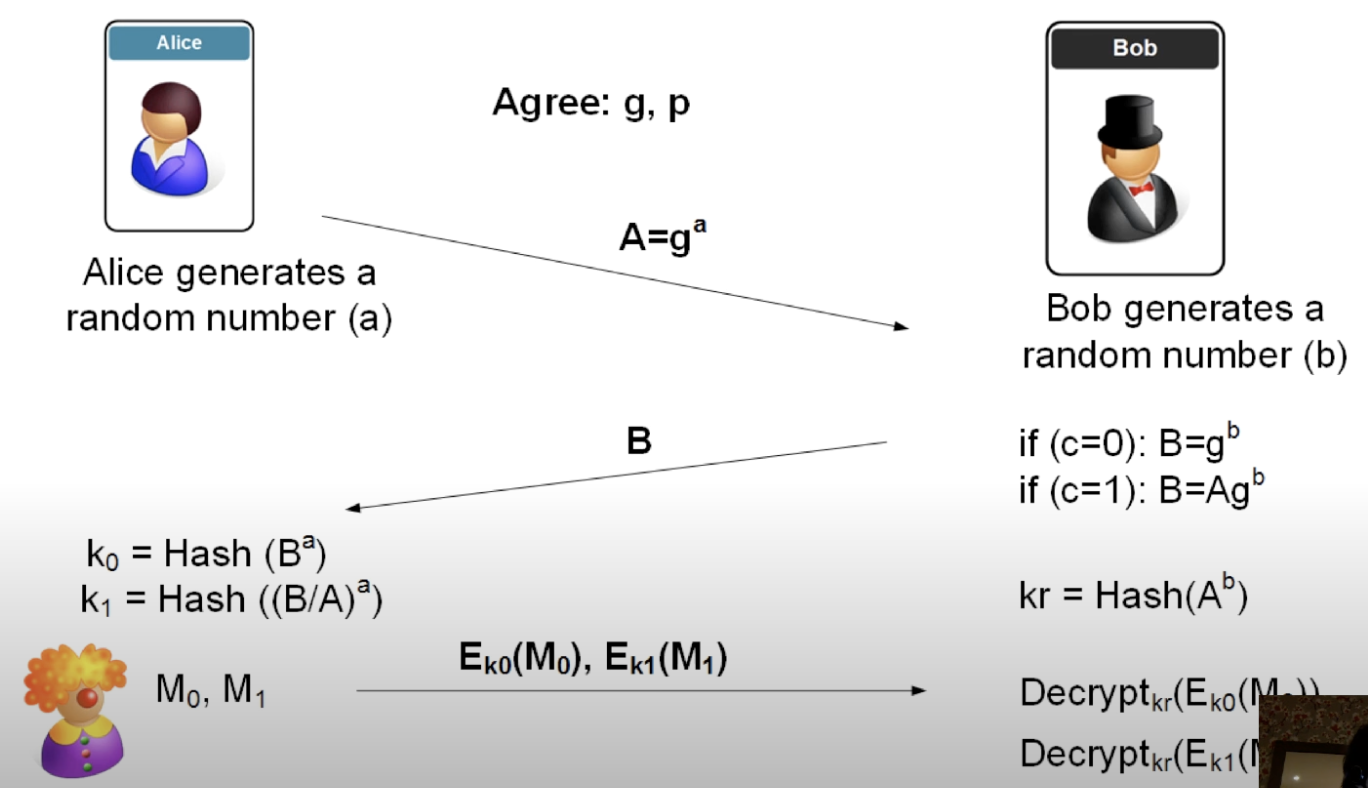

# Garbled circuits

## Yao's garbled circuits

* Number of communication rounds does not depend on circuit depth
* Only usefull for boolean circuits (>,<,=)
* Works only for two parties (extension possible)

We wish to evaluate function $F(x_1, x_2)$ where party P1 holds $x_1$ and party P2 holds $x_2$

### Construction
1) Boolean gate as a lookup table $T_{{x_1},{x_2}} = F(x_1,x_2)$
    * P1 will encrypt T by assigning a randomly-chosen strong key to each possible input $x_1$ and $x_2$, namely $k_{x_1}$ and $k_{x_2}$
    * Send encrypted table to P2
    * Send $k_{x_1}$ in plain text
    * Send $k_{x_2}$ to P2 using 1-out-of-$|X_2|$ oblivious transfer, so that P2 learns only corresponding $x_2$
    * P2 can decrypt only the entry $T_{x_1,x_2}$ corresponding to P2 input
3) Represent $F$ as a boolean circuit $C$ with gates of size 4
    * Cannot reveal the plaintext output of intermediate gates
    * For each wire $w_i$ of $C$, P1 assigns two keys $k^0_i$ and $k^1_i$, corresponding to two possible values on the wire, which we will call _wire labels_
    * P1 sends(only) the active labels of all wires corresponding to the input values to P2. So evaluator can know only the active label, but not its corresponding plaintext value, and not the inactive label
    * Each cell of the look-up table **encrypts the label corresponding to the output computed by the gate**. For each gate P1 builds:

\begin{bmatrix}
           Enc_{k^0_i, k^0_j} (k^{G(0,0)}_t) \\
           Enc_{k^0_i, k^1_j} (k^{G(0,1)}_t) \\
           Enc_{k^1_i, k^0_j} (k^{G(1,0)}_t) \\
           Enc_{k^1_i, k^1_j} (k^{G(1,1)}_t)
\end{bmatrix}

For example, if $G$ is an `AND` gate:

\begin{bmatrix}
           Enc_{k^0_i, k^0_j} (k^0_t) \\
           Enc_{k^0_i, k^1_j} (k^0_t) \\
           Enc_{k^1_i, k^0_j} (k^0_t) \\
           Enc_{k^1_i, k^1_j} (k^1_t)
\end{bmatrix}


## BGW (Ben-Or, Goldwasser, and Wigderson) protocoll

The players hold additive shares of the active wire value.

* Arithmetic circuit over a field F, consisting of **addition**, **multiplication**, and **multiplication-by-constant** gates
* Based on Shamir secret sharing

### Construction

#### Brief
* A dealer chooses a random polynomial $p$ of degree at most $t$, such that $p(0) = \nu$
* Each party $P_i$ holds value $p(i)$ as their share
* For every wire $w$ in the arithmetic circuit, the parties hold a secret-sharing $[v_w]$ of the value $v_w$ on that wire.

#### Input wires
For an input wire belonging to party $P_i$, that party knows the value $\nu$ on that wire in the clear, and distributes shares of $\nu$ to all the parties

#### Addition gate
Given input wires $\alpha$, $\beta$ and output wire $\gamma$. The parties collectively hold sharings of incoming wires $\nu_\alpha$ and $\nu_\beta$ and the goal is to obtain a sharing of $[\nu_\alpha+\nu_\beta]$.
Each party $P_i$ locally adds their shares $p_\alpha(i)+p_\beta(i)$ then $p_\gamma(i)=p_\alpha(i)+p_\beta(i)$ so $p_\gamma(0)=p_\alpha(0)+p_\beta(0)=\nu_\alpha+\nu_\beta$

#### Multiplication gate
The goal is to obtain a sharing of the product $[\nu_\alpha*\nu_\beta]$. Each party $P_i$ locally computes $q(i)=p_\alpha(i)*p_\beta(i)$. The resulting polynomial may have degree as high as $2t$, which is too high.

$q(0) = \sum\limits_{i=1}^{2t+1} \lambda_i q(i)$ - linear function of party's shares, where $\lambda_i$ are Lagrange coefficients

Degree reduction step:
1) Each party $P_i$ generates and **distributes** a threshold-t sharing $[q(i)]$ where $q$ is a polynomial of degree at most $t$ **whose constant coefficient is $q(i)$**
2) The parties compute $[q(0)]=\sum\limits_{i=1}^{2t+1} \lambda_i [q(i)]$ locally. Note that the expression is in terms of addition and multiplication-by constant applied to secret-shared values

Since the values $[q(i)]$ were shared with threshold $t$, the final sharing of $[q(0)]$ also has a threshold $t$ as desired.

#### Output wires
Each party broadcasts its output share to reconstruct output coefficient $p(0) = \nu$

#### Note!
* BGW requires communication/interaction in the form of parties sending shares of $[q(i)]$
* Require $2t+1\le n$ - secure for honest majority by default

## MPC From Preprocessed Multiplication Triples

Split problem into **pre-processing** (before inputs are known) and **online** (after inputs are chosen) phase.

### Beaver triple

**Idea**: move the majority of the communication to the pre-processing phase (e.g. enhance multiplication gate in BGW). 

**Def**: $a$ and $b$ are randomly chosen from the appropriate field, and $c=ab$

One Beaver triple is then "consumed" for each multiplication gate in the eventual protocol. The paradigm is also secure in the presence of malicious adversaries.

Consider multiplication gate with input wires $\alpha$, $\beta$. The parties hold secret sharings of $[\nu_\alpha]$ and $[\nu_\beta]$. To get $[\nu_\alpha]*[\nu_\beta]$ do:
1) Locally compute $[\nu_\alpha - a]$ and publicly open $d = \nu_\alpha - a$ - reveals no information about secret $\nu_\alpha$
2) Locally compute $[\nu_\beta - b]$ and publicly open $e = \nu_\beta - b$
3) $\nu_\alpha\nu_\beta=de+db+ea+c$ so using only local computations get $[\nu_\alpha\nu_\beta]=de+d[b]+e[a]+[c]$

Each party must broadcast two field elements per multiplication, compared to $n$ field elements (across private channels) in the plain BGW protocol.

## Constant-Round Multi-Party Computation: BMR (The Beaver-Micali-Rogaway)

Runs in a **constant (in the depth of the circuit $C$) number of rounds** with security against any **$t<n$** number of corrupt parties among $n$ parties

# Linear secret sharing scheems

## Shamir

Secure if $t<n/2$

## Additive

For a secret $\nu$ each party holds $\nu_i$ where $\sum\limits_{i=1}^n \nu_i = \nu$

Secure against $n-1$ corrupted parties

# Malicious-secure